In [400]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from sklearn.metrics import r2_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
genotype_data = pd.read_csv('genotype_phenotype_wheat/wheat_genotype.csv')
phenotype_data = pd.read_csv('genotype_phenotype_wheat/wheat_phenotype.csv')

For this notebook, I want to work with "fat data", which is very common in the world of genotype-to-phenotype studies. This is where the number of features is significantly larger than the number of samples. Sequencing takes time and genomes are big (particularly the genomes of plants). This particular dataset has about 250 samples of wheat breeding lines, and 7x as many genetic markers. The markers represent single-nucleotide polymorphism locations, coded as {-1,0,1} to represent the aa, aA, and AA alleles (wheat is diploid).

In [92]:
genotype_data

,entgs,GID,wPt.5167,wPt.667814,wPt.3698,wPt.730408,wPt.731090,wPt.4801,wPt.9429,wPt.1582,...,wPt.743082,wPt.732892,wPt.664053,wPt.664198,wPt.666615,wPt.732847,wPt.742879,wPt.743357,wPt.743365,wPt.745114
0,1,5999744,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2,5999769,0.0,0,0.0,NaN,0.0,0.0,0.0,0.0,...,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN
2,3,5999771,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,...,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,4,5999774,0.0,0,0.0,0.0,1.0,0.0,0.0,1.0,...,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
4,5,5999775,0.0,0,0.0,0.0,1.0,0.0,0.0,1.0,...,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,260,6001910,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
250,261,6001911,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
251,262,6001912,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
252,263,6001938,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


We want to investigate some of the phenotypic traits, including: drought yield, irrigated yield, irrigated thousand kernel weight, and irrigated days to heading (which has to do with the photosensitivity).

In [41]:
phenotype_data.head()

,GID,CID,SID,PEDIGREE,Drought Yield,Irrig Yield,Irrig TKW,Irrig DTH
0,5999744,512108,54,BABAX/LR39//BABAX/3/FILIN/2*PASTOR,4.40,7.31,46.5,81.0
1,5999769,512111,71,BABAX/LR42//BABAX/3/VORB,4.34,7.55,44.8,83.5
2,5999771,512111,73,BABAX/LR42//BABAX/3/VORB,4.35,7.67,43.6,81.5
3,5999774,512111,76,BABAX/LR42//BABAX/3/VORB,4.79,8.60,50.8,83.5
4,5999775,512111,77,BABAX/LR42//BABAX/3/VORB,4.66,8.82,48.7,80.0


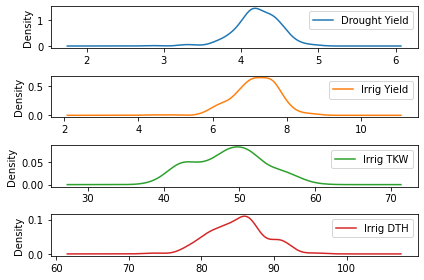

In [90]:
phenotype_data[['Drought Yield', 'Irrig Yield','Irrig TKW', 'Irrig DTH']].plot(kind='density',subplots=True,sharex=False)
plt.tight_layout()

# Predicting drought yield with a Random Forest Regressor

Just to start, I'll use an estimator that I have already played with before, and focus on one trait only. Because I have no idea which parameters to pick, I'll use Bayesian search to explore a broad range of possibilities efficiently.

In [281]:
X = genotype_data.drop(columns = ['entgs','GID'])
y = phenotype_data['Drought Yield']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42,shuffle=True)
pipe = Pipeline([('impute',SimpleImputer(strategy='constant',fill_value=0)),
                ('rfr',RandomForestRegressor())])
cv = ShuffleSplit(n_splits=5,test_size=0.2)

n_estimators = [100,200,400,800,1600,3200,6400,12800]
min_samples_split = np.linspace(2,101,100,dtype=int)
min_samples_leaf = np.linspace(1,100,100,dtype=int)
space = {'rfr__n_estimators': n_estimators,
               'rfr__min_samples_split': min_samples_split,
               'rfr__min_samples_leaf': min_samples_leaf}

search = BayesSearchCV(pipe, space, n_iter=50, n_jobs=-1,n_points=10, cv=cv, random_state=1)
result = search.fit(X_train, y_train)
best_param_dict = {x.replace("rfr__",""): v for x,v in result.best_params_.items()}
optimal_pipe = pipe = Pipeline([('impute',SimpleImputer(strategy='constant',fill_value=0)),
                ('rfr',RandomForestRegressor(**best_param_dict))])
optimal_fit = optimal_pipe.fit(X_train,y_train)
r2_score(y_test,optimal_pipe.predict(X_test))

C:\Users\derek\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0.14543104103068194

This is an OK score, about the same as [published](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7048706/#CR63) work on this. In this paper, they got even more juice out of support vector machines. Let's try them.

# Predicting drought yield with a Support Vector Regressor

In [219]:
svm_pipe = Pipeline([('impute',SimpleImputer(strategy='constant',fill_value=0)),
                ('svr',svm.SVR())])
cv = ShuffleSplit(n_splits=5,test_size=0.2)

epsilon =[0]
C = np.logspace(start=-1,stop=3,num=30)
gamma = np.logspace(start=-4,stop=-2,num=30)
space = {'svr__epsilon': epsilon,
               'svr__C': C,
               'svr__gamma': gamma}

search = BayesSearchCV(svm_pipe, space, n_iter=80, n_jobs=-1,n_points=20,cv=cv, random_state=1,verbose=2)
result = search.fit(X_train, y_train)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Score: 0.2765602279066128
Best Hyperparameters: OrderedDict([('svr__C', 1.743328822199988), ('svr__epsilon', 0), ('svr__gamma', 0.0038566204211634724)])


In [220]:
best_param_dict = {x.replace("svr__",""): v for x,v in result.best_params_.items()}
optimal_svr_pipe = pipe = Pipeline([('impute',SimpleImputer(strategy='constant',fill_value=0)),
                ('svr',svm.SVR(**best_param_dict))])

optimal_svr_fit = optimal_svr_pipe.fit(X_train,y_train)
r2_score(y_test,optimal_svr_pipe.predict(X_test))

0.13350471092715666

Still not terrific. How does this model work on every other y variable?

# Predicting all traits with a Support Vector Regressor

In [248]:
epsilon =np.logspace(start=-8,stop=0,num=1000)
C = np.logspace(start=-1,stop=3,num=1000)
gamma = np.logspace(start=-4,stop=-2,num=1000)
space = {'svr__epsilon': epsilon,
               'svr__C': C,
               'svr__gamma': gamma}
cv = ShuffleSplit(n_splits=5,test_size=0.2,random_state=42)
for col_name in ['Drought Yield','Irrig Yield','Irrig TKW', 'Irrig DTH']:
    y = phenotype_data[col_name]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42,shuffle=True)
    search = BayesSearchCV(svm_pipe, space, n_iter=100, n_jobs=-1,n_points=10,cv=cv, random_state=42,verbose=0)
    result = search.fit(X_train, y_train)
    best_param_dict = {x.replace("svr__",""): v for x,v in result.best_params_.items()}
    optimal_svr_pipe = pipe = Pipeline([('impute',SimpleImputer(strategy='constant',fill_value=0)),
                ('svr',svm.SVR(**best_param_dict))])
    optimal_svr_fit = optimal_svr_pipe.fit(X_train,y_train)
    print(best_param_dict)
    print(col_name+" score: %s" % r2_score(y_test,optimal_svr_pipe.predict(X_test)))

{'C': 2.406475150015424, 'epsilon': 0.0006619433458774388, 'gamma': 0.004088948226294864}
Drought Yield score: 0.13637003191908237
{'C': 2.406475150015424, 'epsilon': 0.0006619433458774388, 'gamma': 0.004088948226294864}
Irrig Yield score: 0.13178326700410625
{'C': 46.41588833612777, 'epsilon': 0.0010115911122238297, 'gamma': 0.002373424250023866}
Irrig TKW score: 0.34170289953990496
{'C': 65.8898955079995, 'epsilon': 0.7175560918936921, 'gamma': 0.004442706749606883}
Irrig DTH score: 0.4695027754324652


The scores are still weak overall, but the prediction is a little better for the latter two phenotypes. In particular, "days to heading" seems like the most promising phenotype to optimize for.

Overall, I think the model is well designed. The Bayesian search let me explore a very fine-grained parameter space, and no extrema were hit. To get better performance, I would need a lot more samples.

It is sort of interesting that the least abstract phenotypes are predicted best by genetic data. The time it takes for the head to appear is more specific than generic yield, for instance. 

Perhaps these "low-level" phenotypic traits can predict "high-level" phenotypes.

# Exploring phenotypic traits

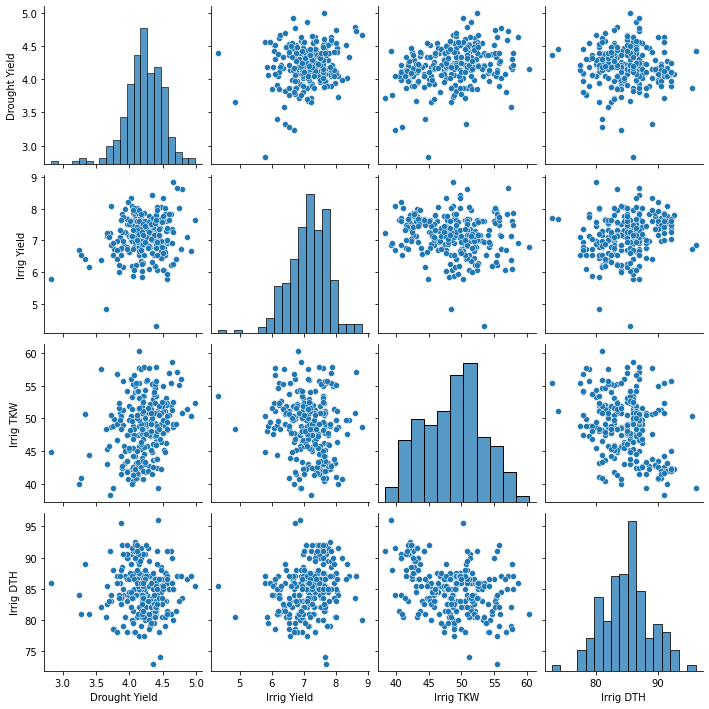

In [386]:
sns.pairplot(phenotype_data[['Drought Yield','Irrig Yield','Irrig TKW', 'Irrig DTH']])

There's actually some observable relationships going on here. In particular, the yield seems to be correlated with the thousand kernel weight. What if we just did a simple linear model comparing these? How predictive would that be?

Irrig Yield score: 0.03418106655939379
Drought Yield score: 0.08760451967055904


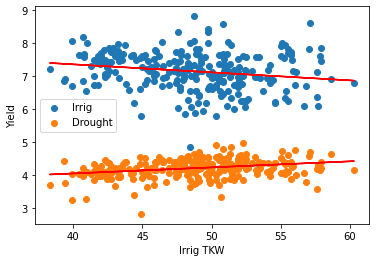

In [390]:
for phenotype in ['Irrig Yield','Drought Yield']:
    X_TKW = np.array(phenotype_data['Irrig TKW']).reshape(-1,1)
    y_IrrigYield = phenotype_data[phenotype]
    lrf = LinearRegression().fit(X_TKW,y_IrrigYield)
    plt.scatter(X_TKW,y_IrrigYield)
    plt.plot(X_TKW,lrf.predict(X_TKW),'r',label='_nolegend_')
    plt.xlabel('Irrig TKW')
    plt.ylabel('Yield')
    plt.legend(['Irrig', 'Drought'])
    print(phenotype+" score: %s" % r2_score(y_IrrigYield,lrf.predict(X_TKW)))

There's a tiny little bit of predictive power, but too weak to be useful. Hence the motivation for doing genome sequencing.  Would it help at all to combine these with the genotype data?

In [379]:
combo_preprocess = ColumnTransformer([('phenotype',MinMaxScaler((-1,1)),['Irrig TKW','Irrig DTH']),
                                ('genotype',SimpleImputer(strategy='constant',fill_value=0),np.linspace(2,1727,1726,dtype=int))])
combo_pipe = Pipeline([('combo_preprocess',combo_preprocess),('svr',svm.SVR())])

In [384]:
epsilon =np.logspace(start=-8,stop=0,num=1000)
C = np.logspace(start=-1,stop=3,num=1000)
gamma = np.logspace(start=-4,stop=-2,num=1000)
space = {'svr__epsilon': epsilon,
               'svr__C': C,
               'svr__gamma': gamma}

for col_name in ['Drought Yield','Irrig Yield']:
    y = phenotype_data[col_name]
    X_train, X_test, y_train, y_test = train_test_split(X_combo,y,test_size=0.20,random_state=42,shuffle=True)
    search = BayesSearchCV(combo_pipe, space, n_iter=100, n_jobs=-1,n_points=10,cv=cv, random_state=42,verbose=0)
    result = search.fit(X_train, y_train)
    best_param_dict = {x.replace("svr__",""): v for x,v in result.best_params_.items()}
    optimal_combo_pipe = pipe = Pipeline([('combo_preprocess',combo_preprocess),('svr',svm.SVR(**best_param_dict))])
    optimal_combo_fit = optimal_combo_pipe.fit(X_train,y_train)
    print(best_param_dict)
    print(col_name+" score: %s" % r2_score(y_test,optimal_combo_pipe.predict(X_test)))

{'C': 1.2975171686575875, 'epsilon': 0.0001691329517029647, 'gamma': 0.002362508465477945}
Drought Yield score: 0.11953405571775355
{'C': 9.246257116405738, 'epsilon': 0.005724766239702178, 'gamma': 0.002330061410696925}
Irrig Yield score: 0.15393579963884585


No, it doesnt really add to the prediction because the trait features themselves are not all that powerful.

# Conclusions 

To summarize what I've learned here, both random forests and support vector regressors are viable options for predicting phenotype from genotype. However, the predictions are very weak, even when I optimize hyperparameters using a Bayesian search. I did find that phenotypic traits that are "closer" to specific biological processes (e.g. days to heading) were better predicted, whereas traits that are likely comprised of many biological processes (yield) were significantly weaker. Given this, perhaps it would be worthwhile to break down the key determinants of yield, and make predictions with these features. 